In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , Normalizer , MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import plotly.express as px
from sklearn.metrics import silhouette_samples , silhouette_score
from sklearn.cluster import DBSCAN

# Data Exploration

In [4]:
df = pd.read_csv("data.csv")
df.columns

Index(['Unnamed: 0', 'name', 'brand', '2G', '3G', '4G', '5G', 'Announced',
       'Status', 'Weight', 'Length', 'Width', 'Diameter', 'SIM',
       'Display Type', 'Display Size', 'ppi', 'body ratio', 'OS',
       'battery_capacity', 'Price', 'CPU', 'ratio', 'pixel', 'WLAN', 'Colors',
       'Sensors', 'Bluetooth', 'GPU', 'Loudspeaker', '3.5mm jack', 'Chipset',
       'Network', 'Internal', 'Card slot', 'RAM', 'Storage'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2651 non-null   int64  
 1   name              2651 non-null   object 
 2   brand             2651 non-null   object 
 3   2G                2651 non-null   bool   
 4   3G                2651 non-null   bool   
 5   4G                2651 non-null   bool   
 6   5G                2651 non-null   bool   
 7   Announced         2651 non-null   float64
 8   Status            2651 non-null   object 
 9   Weight            2651 non-null   float64
 10  Length            2651 non-null   object 
 11  Width             2651 non-null   object 
 12  Diameter          2651 non-null   object 
 13  SIM               2651 non-null   object 
 14  Display Type      2651 non-null   object 
 15  Display Size      2651 non-null   float64
 16  ppi               2651 non-null   float64


## Outlier detection

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
ابتدا داده‌های پرت دو ستون هدف را با حد بالا و پایین هر ستون جایگرین کرده‌ایم 
</font>
</p>

In [6]:
class OutlierDetector:
    def __init__(self, df):
        self.df = df

    def detect_and_replace(self):
        for col in self.df.columns:
            if col in ['Price' , 'battery_capacity']:
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                self.df[col] = np.where(self.df[col] < lower_bound, lower_bound, self.df[col])
                self.df[col] = np.where(self.df[col] > upper_bound, upper_bound, self.df[col])
        return self.df

In [7]:
outlier_detector = OutlierDetector(df)
df = outlier_detector.detect_and_replace()

## Scaling

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
داده‌ها را اسکیل می‌کنیم.  
</font>
</p>

In [8]:
df[['Price_scaled' , 'battery_capacity_scaled']]= df[['Price' , 'battery_capacity']]

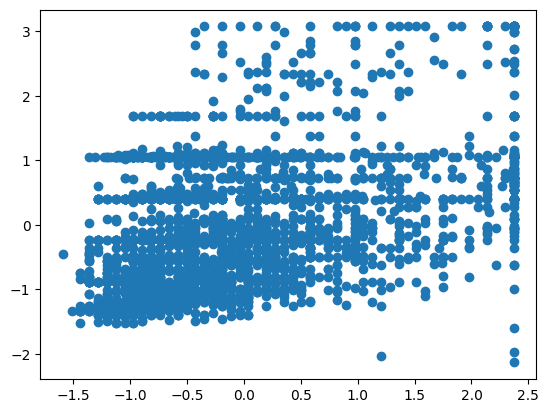

In [9]:
scaler = StandardScaler()
df[['Price_scaled' , 'battery_capacity_scaled']] = scaler.fit_transform(df[['Price' , 'battery_capacity']])
plt.scatter(df['Price_scaled'] ,  df['battery_capacity_scaled'])

## Clustering with K-means, n_clusters=5

In [10]:
kmeans = KMeans(n_clusters=5 , random_state=42)
kmeans.fit(df[['Price_scaled' , 'battery_capacity_scaled']])

KMeans(n_clusters=5, random_state=42)

In [11]:
df['kmeans_5'] = kmeans.labels_

In [12]:
df['kmeans_5'].unique()

array([2, 1, 4, 0, 3])

In [13]:
kmeans.cluster_centers_

array([[ 1.89014732,  0.52950558],
       [ 0.34123601, -0.35243916],
       [-0.76890543, -0.8641156 ],
       [ 1.18894165,  2.62180591],
       [-0.38950603,  0.82499105]])

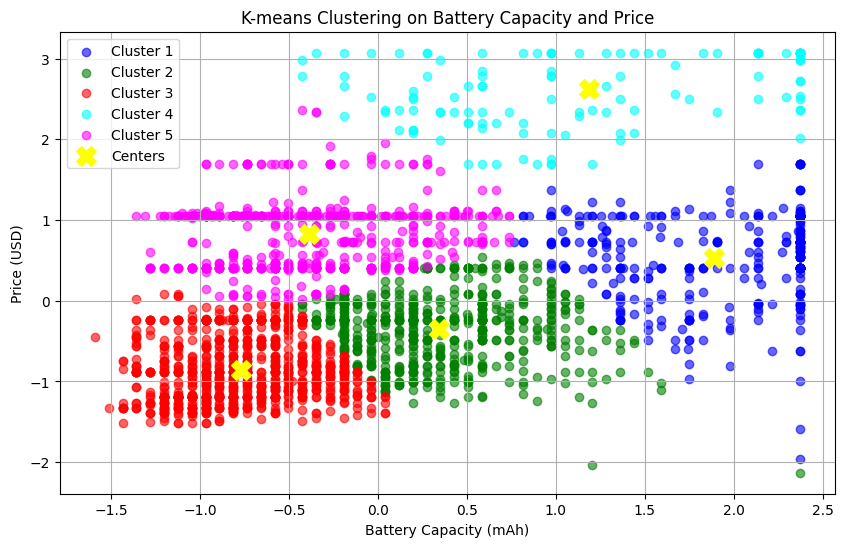

In [14]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for i in range(5):
    # Plot points belonging to the current cluster
    cluster_data = df[df['kmeans_5'] == i]
    plt.scatter(cluster_data['Price_scaled'], cluster_data['battery_capacity_scaled'], color=colors[i], label=f'Cluster {i+1}', alpha=0.6)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, color='yellow', marker='X', label='Centers')

plt.title('K-means Clustering on Battery Capacity and Price')
plt.xlabel('Battery Capacity (mAh)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Elbow Plot


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
به کمک نقطه شکست این پلات می‌توانیم تشخیص بدهیم بهترین خوشه‌ها در چه محدوده‌ای قرار دارند. بر این اساس محدوده ۲ تا ۶ خوشه را انتخاب می‌کنیم.
</font>
</p>

In [15]:
def optimise_k_means(data , max_k):
    means = []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)
    fig = plt.subplots(figsize=(10,7))
    plt.plot(means , inertias , 'o-')
    plt.xlabel('Number of Clusters(K)') 
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()   

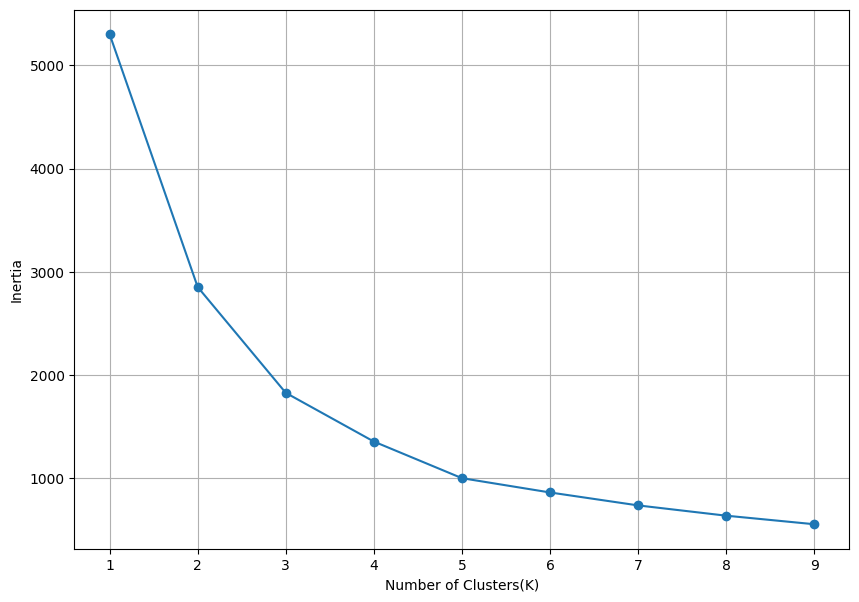

In [16]:
optimise_k_means(df[['Price_scaled' , 'battery_capacity_scaled']] , 10)

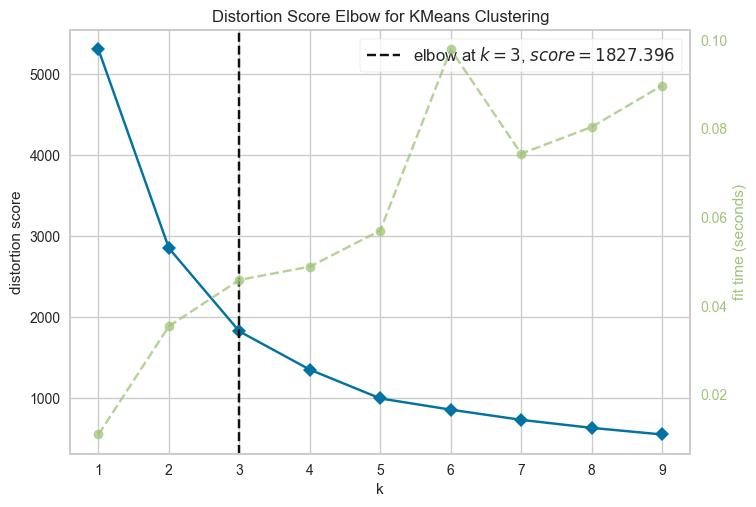

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
from yellowbrick.cluster import KElbowVisualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(df[['battery_capacity_scaled' , 'Price_scaled']])        # Fit the data to the visualizer
visualizer.show()

## Checking Silhouette Scores

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
برای خوشه‌بندی با ۲ تا ۶ کلاس مقدار سیلوئت اسکور را محاسبه می‌کنیم. نتایج نشان می‌دهد ۳ کلاس بهرین مقدار برای خوشه‌بندی این داده است.
</font>
</p>

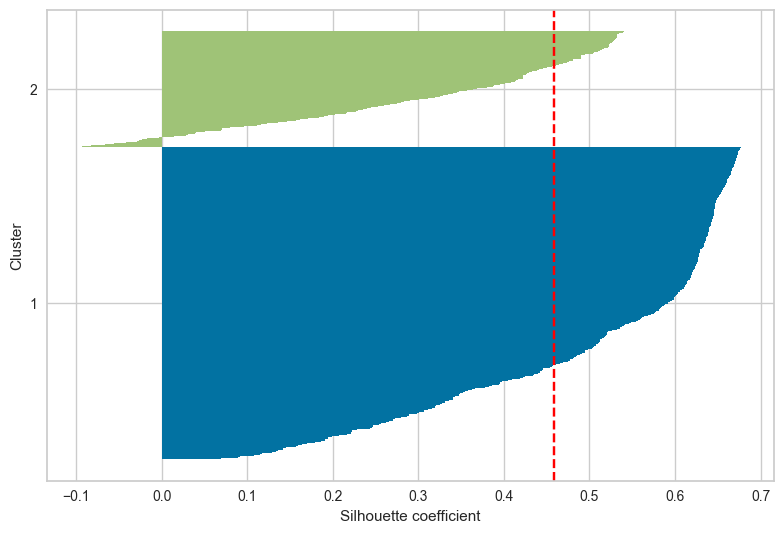

0.4585616697287426


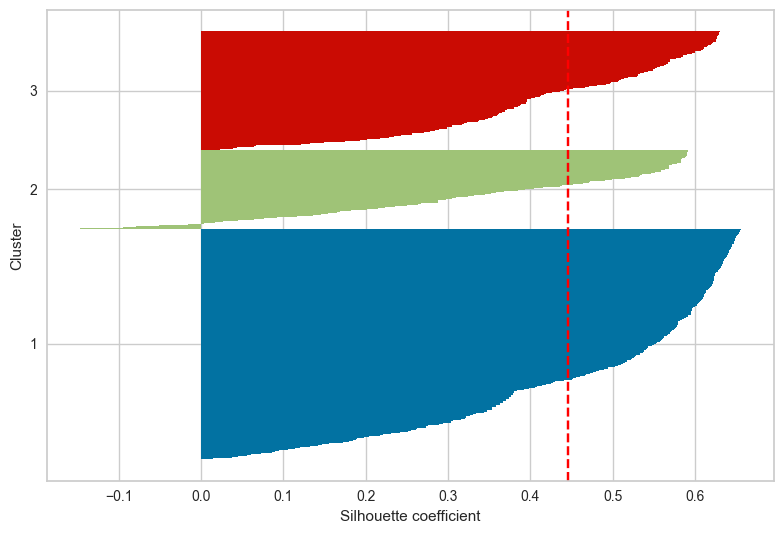

0.4455895520935578


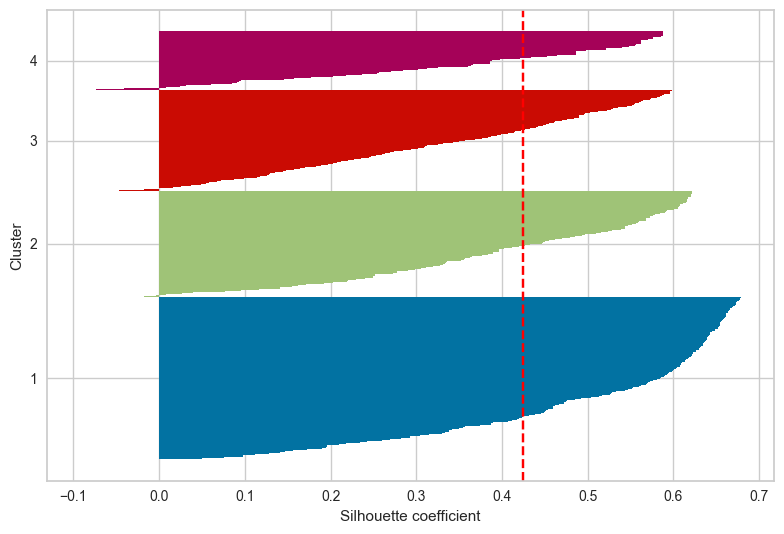

0.4241131369415214


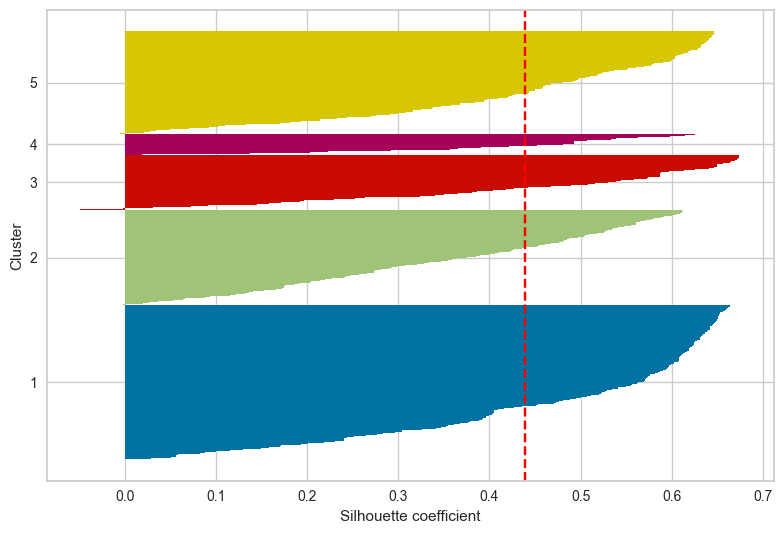

0.4386541426735023


In [18]:
for k in range(2, 6):
    km = KMeans(n_clusters=k)
    X = df[['Price_scaled' , 'battery_capacity_scaled']]
    y_km = km.fit(X)
    y_km = km.labels_
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                edgecolor='none')

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
        
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()
    print(silhouette_score(X, y_km))

## Chossing n_clusters=3 based on Elbow plot and Silhouette Scores

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
طبق این خوشه‌بندی داده‌ها به سه دسته تقسیم می‌شوند. آبی) گوشی‌های با ظرفیت باتری پایین تا متوسط و قیمت نسبتا پایین. قرمز) گوشی‌های با ظرفیت باتری پایین تا متوسط و قیمت نسبتا بالا. سبز) گوشی‌های با ظرفیت باتری متوسط به بالا و قیمت‌های متنوع
</font>
</p>

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['Price_scaled' , 'battery_capacity_scaled']])
df['kmeans_3'] = kmeans.labels_
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for i in range(3):
    cluster_data = df[df['kmeans_3'] == i]
    plt.scatter(cluster_data['Price_scaled'], cluster_data['battery_capacity_scaled'], color=colors[i], label=f'Cluster {i+1}', alpha=0.6)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, color='yellow', marker='X', label='Centers')

plt.title('K-means Clustering on Battery Capacity and Price')
plt.xlabel('Battery Capacity (mAh)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


## DBSCAN

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
برای اجرای این الگوریتم یک بار بدون حذف داده‌های پرت مدل را آموزش داده‌ایم. 
</font>
</p>

## Without droping outliers

In [20]:
df = pd.read_csv("data.csv")
df[['Price_scaled' , 'battery_capacity_scaled']]= df[['Price' , 'battery_capacity']]
caler = StandardScaler()
df[['Price_scaled' , 'battery_capacity_scaled']] = scaler.fit_transform(df[['Price' , 'battery_capacity']])

In [21]:
dbscan = DBSCAN(eps=0.6, min_samples=30)

In [22]:
labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
np.unique(labels)

array([-1,  0], dtype=int64)

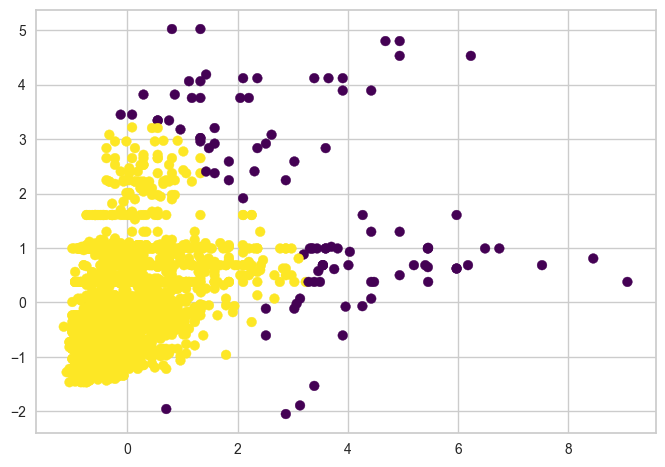

In [23]:
plt.scatter(df["Price_scaled"] , df["battery_capacity_scaled"], c=labels, cmap='viridis')

## Searching in hyperparameters to find possible models that produce three clusters 

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
در قطعه کد‌های زیر در بازه‌هایی متفاوت از اپسیلون و حداقل نمونه جستجو کرده‌ایم تا مدل‌هایی را پیدا کنیم که داده را به سه خوشه تقسیم می‌کنند.
</font>
</p>

In [24]:
list_minpt = []
list_eps = []
for eps in np.arange(0.1,5,0.1).astype(float): 
    for minpt in range (5,60,5):
        dbscan = DBSCAN(eps=eps, min_samples=minpt)
        labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
        list_labels = list(np.unique(labels))
        if len(list_labels) == 3:
            list_eps.append(eps)
            list_minpt.append(minpt)

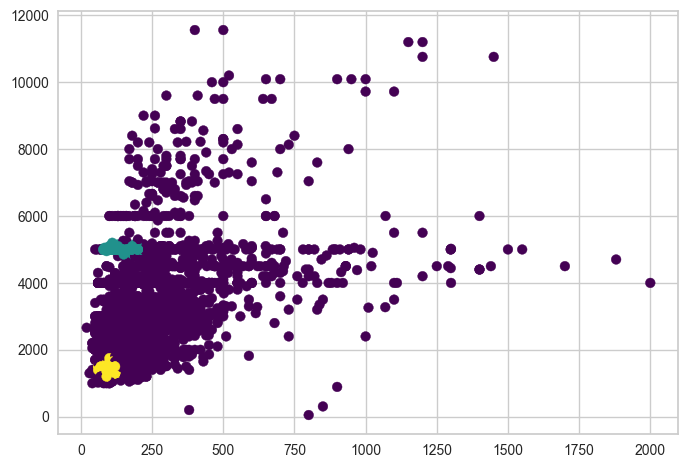

eps= 0.1 min_samples= 55
-0.1460582443946223


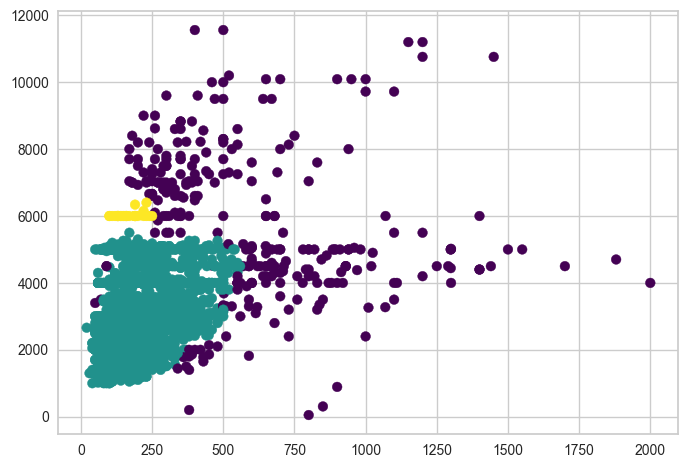

eps= 0.2 min_samples= 15
0.3224754773477632


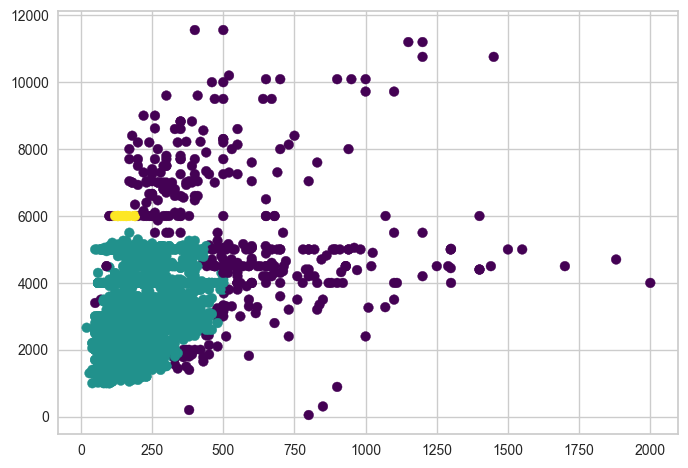

eps= 0.2 min_samples= 20
0.29439439703002274


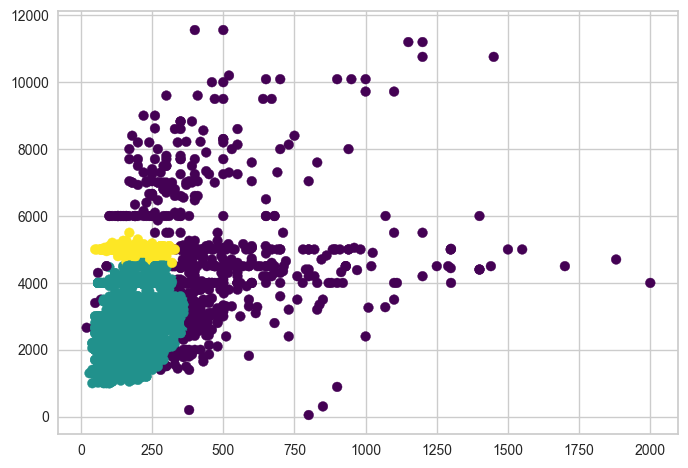

eps= 0.2 min_samples= 40
0.3107745295048545


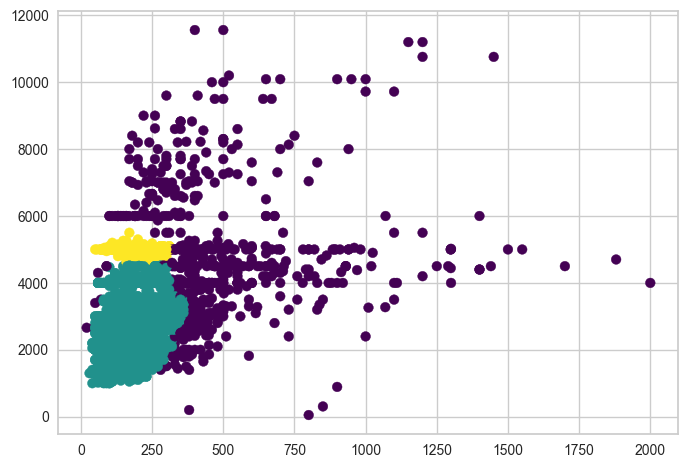

eps= 0.2 min_samples= 45
0.3059720108313492


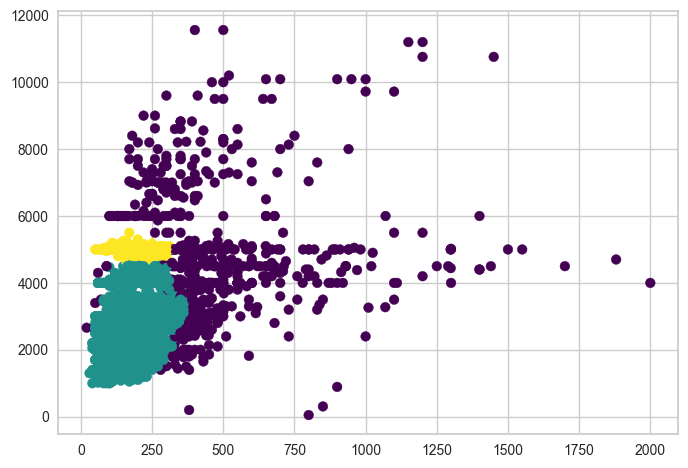

eps= 0.2 min_samples= 50
0.3051304802242596


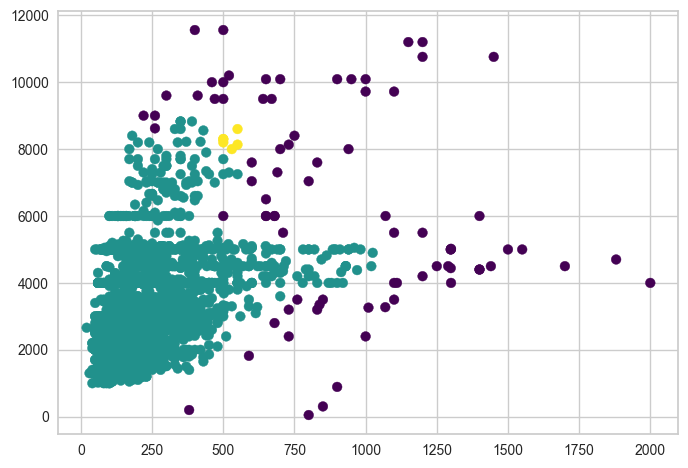

eps= 0.30000000000000004 min_samples= 5
0.5081203695973623


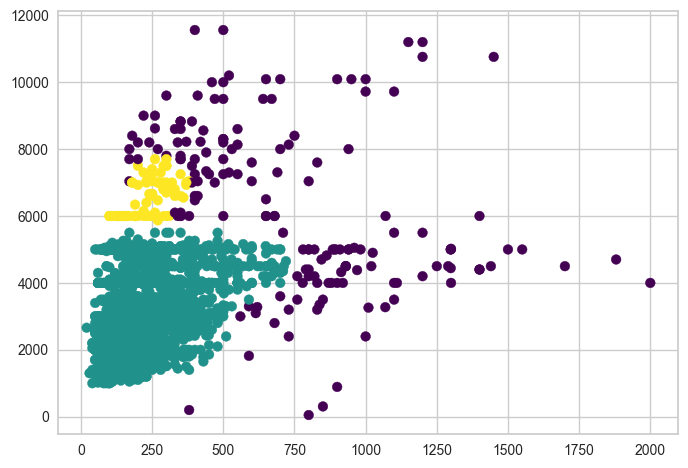

eps= 0.30000000000000004 min_samples= 15
0.44703557252253423


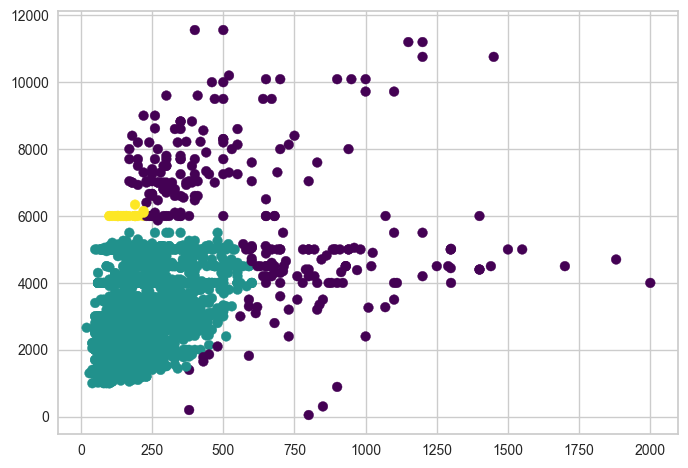

eps= 0.30000000000000004 min_samples= 25
0.3362795606393983


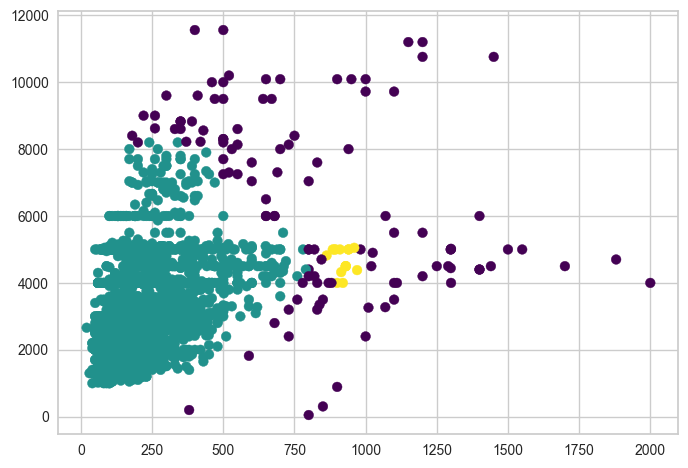

eps= 0.4 min_samples= 15
0.07439169209737596


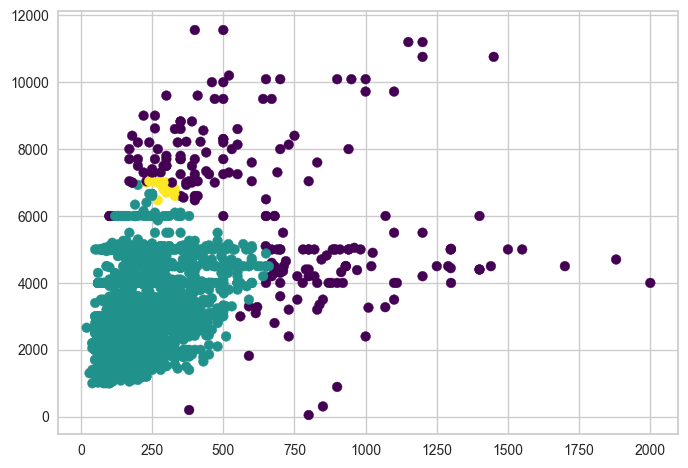

eps= 0.4 min_samples= 35
0.4325649411145207


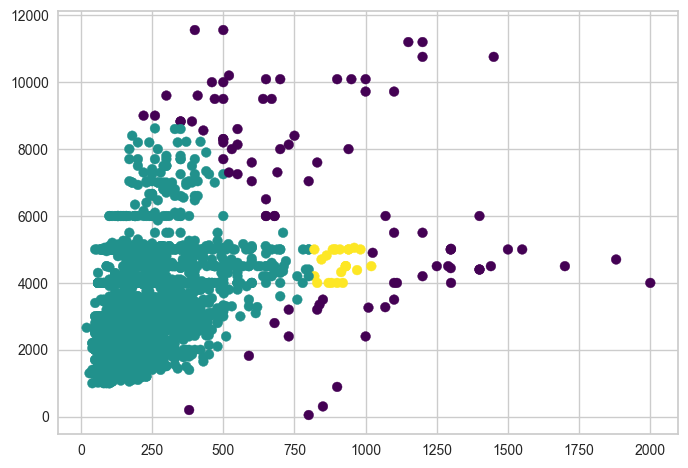

eps= 0.5 min_samples= 20
0.0572004122841773


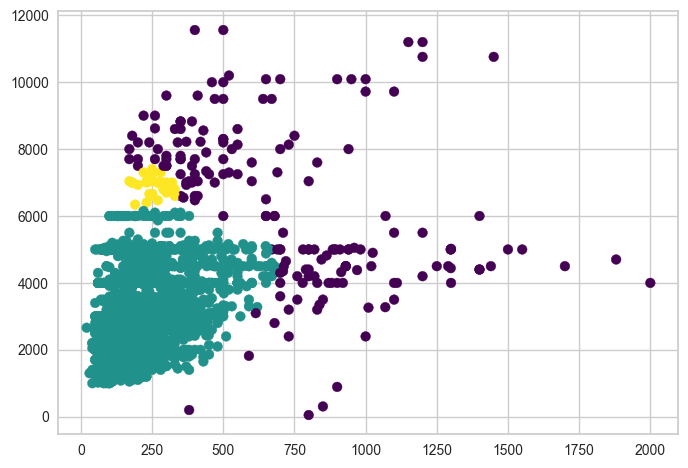

eps= 0.5 min_samples= 50
0.4560803318970681


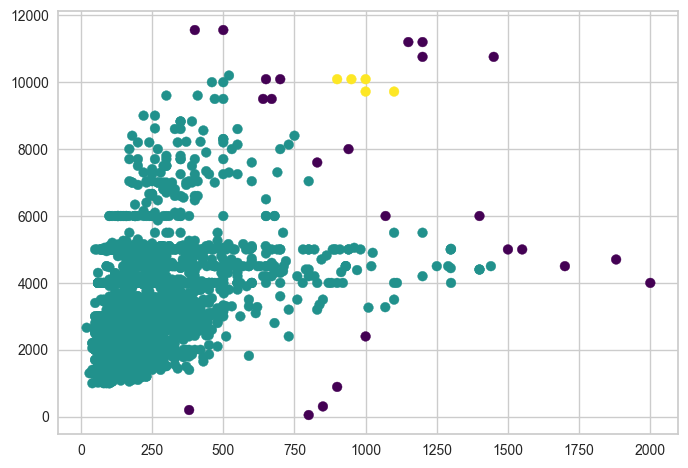

eps= 0.6 min_samples= 5
0.6043679392511306


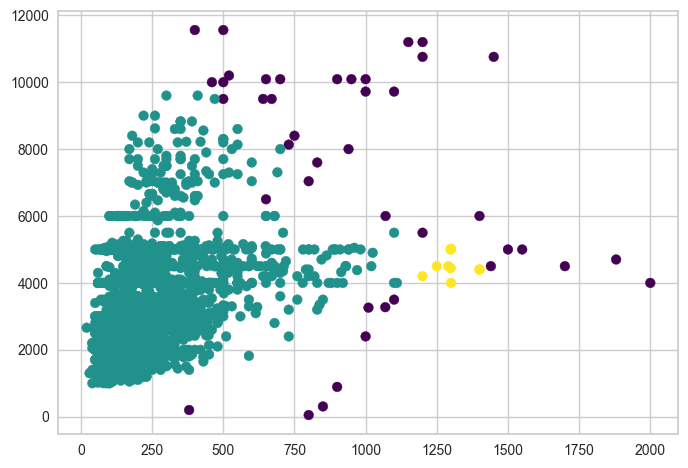

eps= 0.6 min_samples= 10
0.11944788441858929


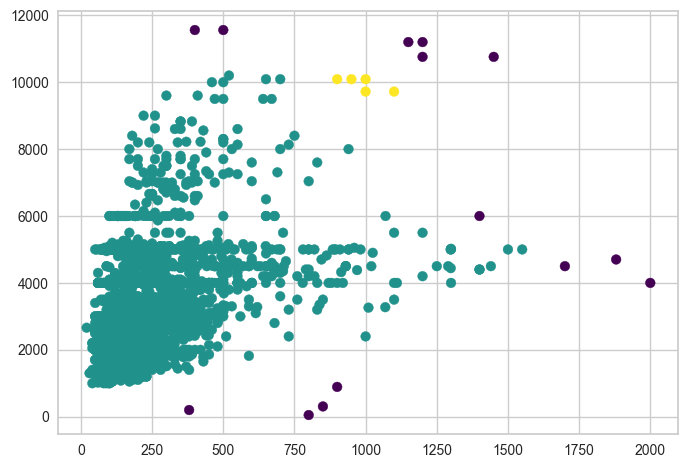

eps= 0.7000000000000001 min_samples= 5
0.6200199466946935


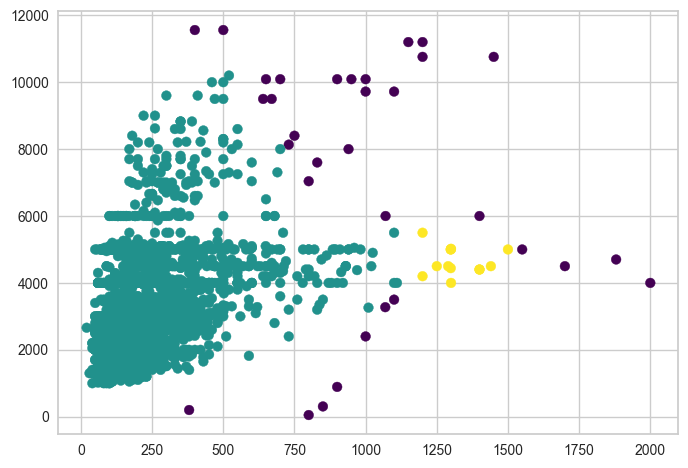

eps= 0.7000000000000001 min_samples= 10
0.14007213541747415


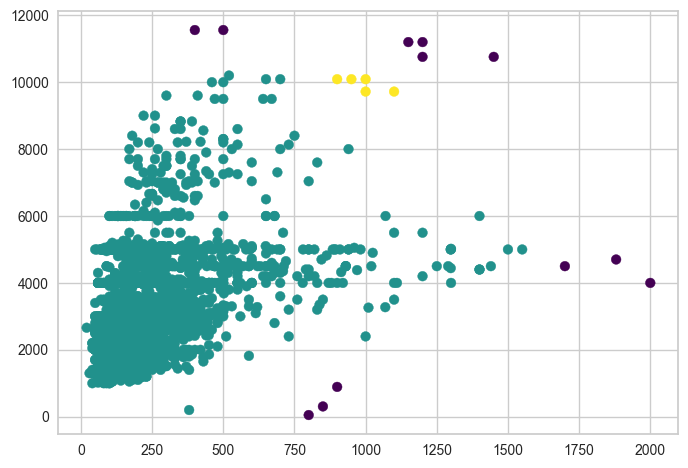

eps= 0.8 min_samples= 5
0.6382285754452424


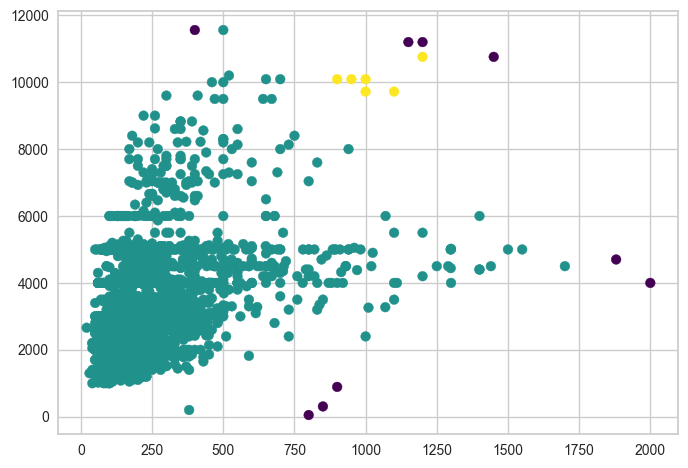

eps= 0.9 min_samples= 5
0.6273535968437759


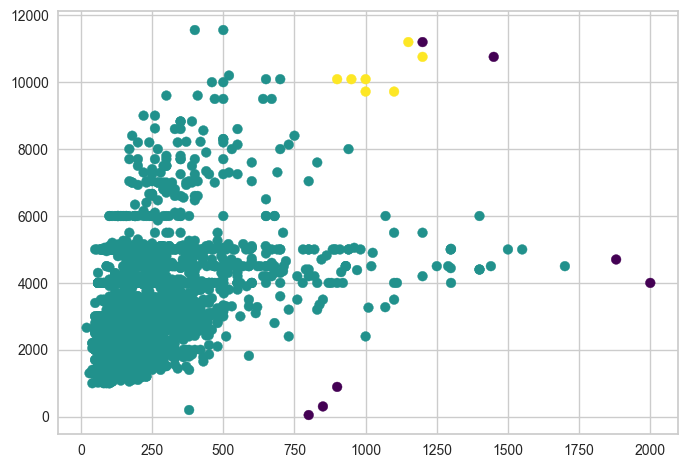

eps= 1.0 min_samples= 5
0.5657408739065344


In [25]:
for i in range (len(list_eps)):
        dbscan = DBSCAN(eps=list_eps[i], min_samples=list_minpt[i])
        labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
        X = df[["Price" , "battery_capacity"]]
        list_labels = list(np.unique(labels))
        plt.scatter(df["Price"] , df["battery_capacity"], c=labels, cmap='viridis')
        plt.show()
        print('eps=',list_eps[i], 'min_samples=',list_minpt[i])
        print(silhouette_score(X ,labels))

## Choosing the best Model based on silhouette_score

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
بر اساس میزان سیلوئت‌اسکور هایپرپارامتر‌ها را انتخاب کرده و مجددا مدل را اجرا می‌کنیم. نتیجه خوشه‌بندی سه دسته را نشان می‌دهد. خوشه بنفش گوشی‌های با ظرفیت باتری نسبتا کم و قیمت نسبتا کم، خوشه زرد گوشی‌های با ظرفیت باتری نسبتا کم و قیمت متوسط هستند و سایر نقاط به عنوان نویز در نظر گرفته شده‌اند
</font>
</p>

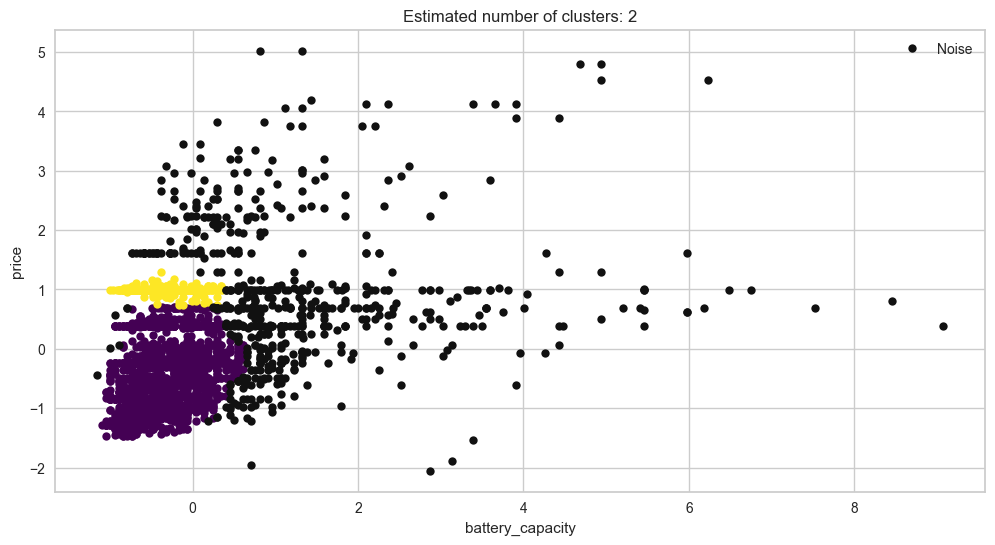

0.3059720108313492


In [26]:
dbscan = DBSCAN(eps=0.2, min_samples=45)
labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
df['labels'] = labels
X = df[["Price" , "battery_capacity"]]
cmap = plt.cm.viridis
labels_unique = (df['labels'].unique())
n_clusters_ = len(set(labels_unique)) - (1 if -1 in labels_unique else 0)
labels_unique = labels_unique[labels_unique != -1]  # Exclude noise label for color map
colors = cmap(np.linspace(0, 1, len(labels_unique)))

plt.figure(figsize=(12, 6))

# Plot each cluster
for k, col in zip(labels_unique, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == k)

    xy = df[['Price_scaled' , 'battery_capacity_scaled']][class_member_mask]
    plt.plot(xy['Price_scaled'], xy['battery_capacity_scaled'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

# Noise
xy = df[['Price_scaled' , 'battery_capacity_scaled']][df['labels'] == -1]
plt.plot(xy['Price_scaled'], xy['battery_capacity_scaled'], 'o', markerfacecolor='k', markeredgecolor='k', markersize=6, label='Noise')

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.xlabel('battery_capacity')
plt.ylabel('price')
plt.legend()

plt.show()
print(silhouette_score(X ,labels))

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
اپسیلون(eps)
</font>
</p>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color=blue> 
 حداکثر فاصله بین دو نمونه  برای اینکه در همسایگی هم در نظر گرفته شوند. مقدار اپسیلون کوچکتر به این معنی است که نقاط باید به هم نزدیکتر باشند تا بخشی از یک خوشه در نظر گرفته شوند که منجر به تعداد بیشتر خوشه‌های کوچکتر می‌شود. همچنین اپسیلون کوچکتر می تواند منجر به طبقه بندی بسیاری از نقاط به عنوان نویز شود. 
 برعکس، یک مقدار اپسیلون بزرگتر باعث می‌شود نقاط دورتر از هم  بخشی از یک خوشه در نظر گرفته شوند، که به طور بالقوه منجر به خوشه های کمتر و بزرگتر می شود.
</font>
</p>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
حداقل نمونه (min_samples)
</font>
</p>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color=blue> 
این هایپرپارامتر تعداد نمونه ها را در یک همسایگی برای اینکه یک نقطه به عنوان نقطه مرکزی در نظر گرفته می شود، تعیین می‌کند. درواقع حداقل اندازه خوشه را  نشان می‌دهد. نقاط مرکزی آنهایی هستند که به اندازه حداقل نقاط نمونه در همسایگی اپسیلون خود دارند.
اگر این هایپرپارامتر کوچک باشد می تواند منجر به گنجاندن تعداد بیشتری از نقاط در خوشه‌ها شود که حساسیت به نویز را افزایش می‌دهد. در این صورت خوشه ها ممکن است حتی در مناطق کم تراکم تشکیل شوند.
اگر این هایپرپارامتر بزرگ باشد خوشه‌ها برای ایجاد شدن باید چگال‌تر باشند. در این صورت خوشه های کمتری ایجاد می‌شود و در این صورت  الگوریتم در برابر نویز قوی تر می‌شود، زیرا برای تشکیل یک خوشه به نقاط بیشتری نیاز است.
</font>
</p>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color=blue> 
تعامل بین اپسیلون و حداقل‌نمونه در فرآیند خوشه‌بندی دی‌بی‌اسکن بسیار مهم است. 
 ترکیب اپسیلون کوچک و حداقل‌نمونه بزرگ می‌تواند منجر به دسته‌بندی بسیاری از نقاط به عنوان نویز شود و در نتیجه خوشه‌های کمتر و احتمالاً معنی‌دارتر می‌شود، اما ممکن است خوشه‌های کوچک‌تر را از بین بروند.
 ترکیب اپسیلون بزرگ و حداقل‌نمونه کوچک می‌تواند منجر به خوشه‌های بسیار وسیع شود، به طوری که گروه‌های متمایز ممکن است در خوشه‌های کمتر ادغام شوند و به طور بالقوه تمایزات معنی‌دار در داده‌ها را پنهان کنند.
</font>
</p>


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color=red> 
در مدل انتخابی ما اپسیلون نسبتا کوچک و حداقل نمونه عددی متوسط در نظر گرفته شده‌است. این انتخاب حاصل جستجو در بازه‌های مختلف برای هر دو هایپرپارامتر و بررسی میزان سیلوئت اسکور بوده‌است.
</font>
</p>

# Extra

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5 color=blue> 
در ادامه یک‌بار دیگر مراحل بالا را تکرار کرده‌ایم و این بار داده‌های پرت را از مجموعه داده حذف کرده‌ایم. 
</font>
</p>

## With droping outliers

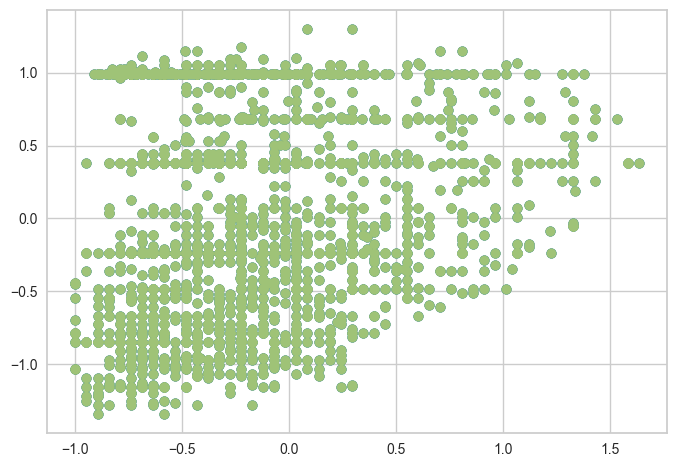

In [27]:
from sklearn.ensemble import IsolationForest
df[['Price_scaled' , 'battery_capacity_scaled']]= df[['Price' , 'battery_capacity']]
scaler = StandardScaler()
df[['Price_scaled' , 'battery_capacity_scaled']] = scaler.fit_transform(df[['Price' , 'battery_capacity']])
if_ = IsolationForest()
df['is_outlier']= if_.fit_predict(df[['Price' , 'battery_capacity']])
df[['Price_scaled' , 'battery_capacity_scaled']]= df[['Price_scaled' , 'battery_capacity_scaled']].loc[df['is_outlier'] == 1]
df = df.dropna()
plt.scatter(df['Price_scaled'] ,  df['battery_capacity_scaled'])
plt.scatter(df['Price_scaled'] ,  df['battery_capacity_scaled'])

In [28]:
dbscan = DBSCAN(eps=0.6, min_samples=30)

In [29]:
labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
np.unique(labels)

array([0], dtype=int64)

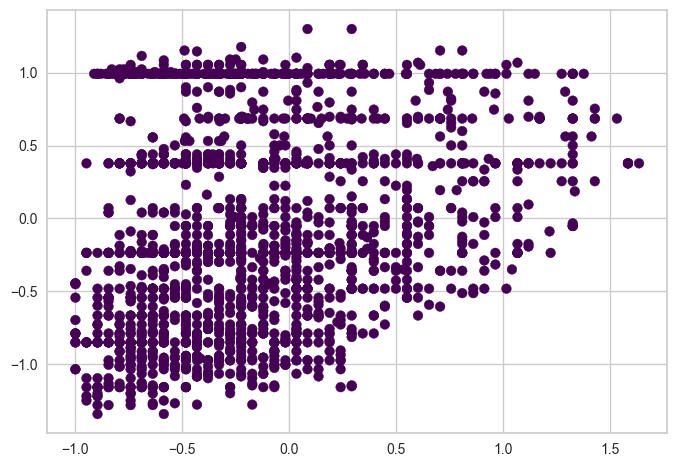

In [30]:
plt.scatter(df["Price_scaled"] , df["battery_capacity_scaled"], c=labels, cmap='viridis')

## Searching in hyperparameters to find possible models that produce three clusters 

In [31]:
list_minpt = []
list_eps = []
for eps in np.arange(0.1,5,0.1).astype(float): 
    for minpt in range (5,60,5):
        dbscan = DBSCAN(eps=eps, min_samples=minpt)
        labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
        list_labels = list(np.unique(labels))
        if len(list_labels) == 3:
            list_eps.append(eps)
            list_minpt.append(minpt)


In [33]:
list_minpt

[55, 40, 45]

In [34]:
list_eps

[0.1, 0.2, 0.2]

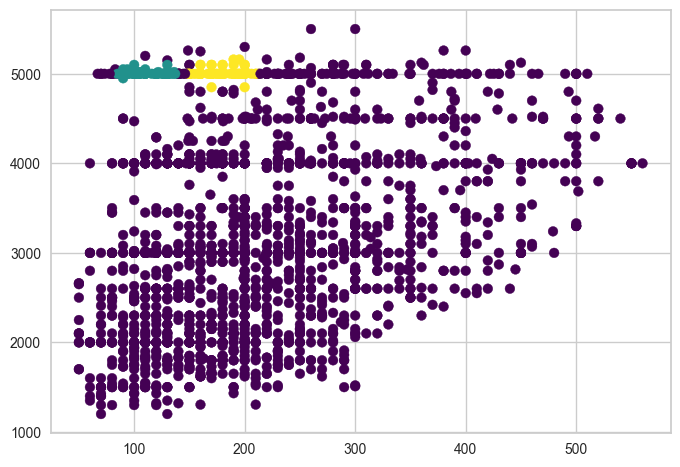

eps= 0.1 min_samples= 55
0.2668614763946614


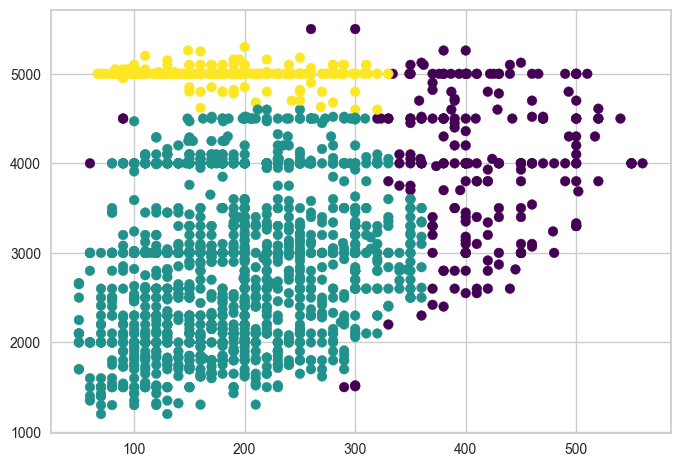

eps= 0.2 min_samples= 40
0.2877739668822547


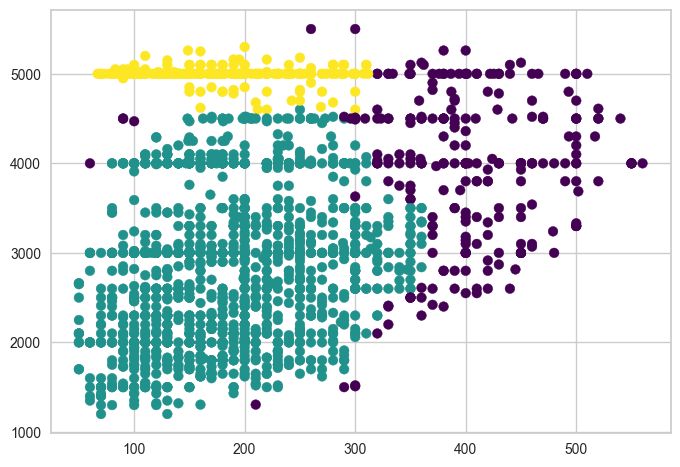

eps= 0.2 min_samples= 45
0.2889023071556443


In [35]:
for i in range (len(list_eps)):
        dbscan = DBSCAN(eps=list_eps[i], min_samples=list_minpt[i])
        labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
        X = df[["Price" , "battery_capacity"]]
        list_labels = list(np.unique(labels))
        plt.scatter(df["Price"] , df["battery_capacity"], c=labels, cmap='viridis')
        plt.show()
        print('eps=',list_eps[i], 'min_samples=',list_minpt[i])
        print(silhouette_score(X ,labels))

## Choosing the best Model based on silhouette_score

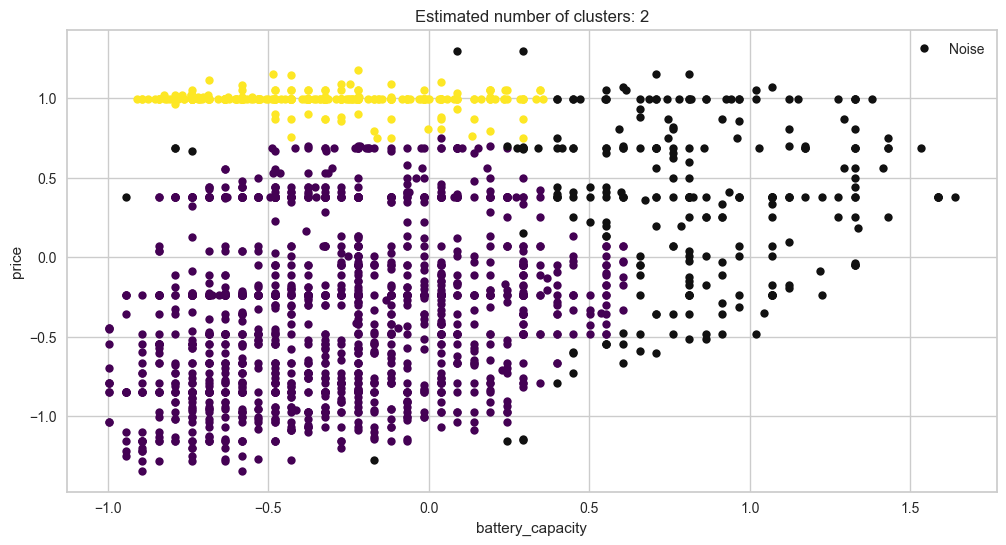

0.2889023071556443


In [36]:
dbscan = DBSCAN(eps=0.2, min_samples=45)

labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
df['labels'] = labels
X = df[["Price" , "battery_capacity"]]
cmap = plt.cm.viridis
labels_unique = (df['labels'].unique())
n_clusters_ = len(set(labels_unique)) - (1 if -1 in labels_unique else 0)
labels_unique = labels_unique[labels_unique != -1]  
colors = cmap(np.linspace(0, 1, len(labels_unique)))

plt.figure(figsize=(12, 6))

for k, col in zip(labels_unique, colors):
    if k == -1:
        col = 'k'
    class_member_mask = (labels == k)

    xy = df[['Price_scaled' , 'battery_capacity_scaled']][class_member_mask]
    plt.plot(xy['Price_scaled'], xy['battery_capacity_scaled'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)


xy = df[['Price_scaled' , 'battery_capacity_scaled']][df['labels'] == -1]
plt.plot(xy['Price_scaled'], xy['battery_capacity_scaled'], 'o', markerfacecolor='k', markeredgecolor='k', markersize=6, label='Noise')

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.xlabel('battery_capacity')
plt.ylabel('price')
plt.legend()

plt.show()
print(silhouette_score(X ,labels))


# Some extra Charts

In [37]:
df4 = df.groupby(['Announced', 'labels']).count().reset_index()
df4['name']
fig = px.bar(df4[['Announced' , 'name' , 'labels' ]], x='Announced', y='name' ,color='labels', title="the number of each cluster per year")
fig.show()

In [38]:
df5 = df.groupby(['brand', 'labels']).count().reset_index()
fig = px.bar(df5[['name' , 'brand' , 'labels' ]], x='brand', y='name' ,color='labels', title="the number of each cluster per brand")
fig.show()